<a href="https://colab.research.google.com/github/tusharlawande/Data-Science-Intern-Assignment-Zeotap/blob/main/Intership_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Customers Dataset:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Dataset:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166   

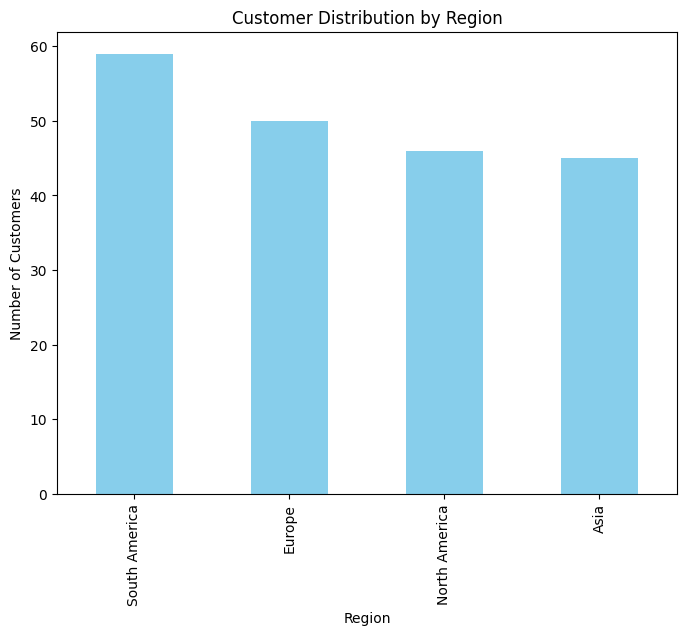

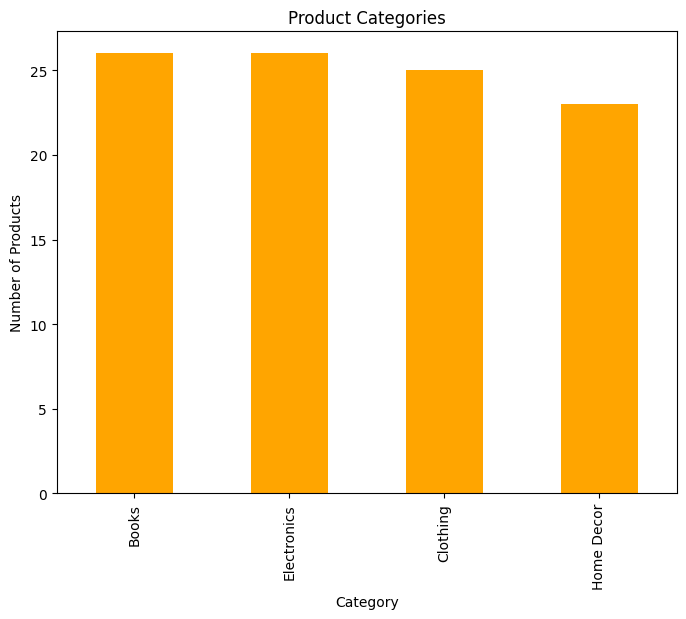

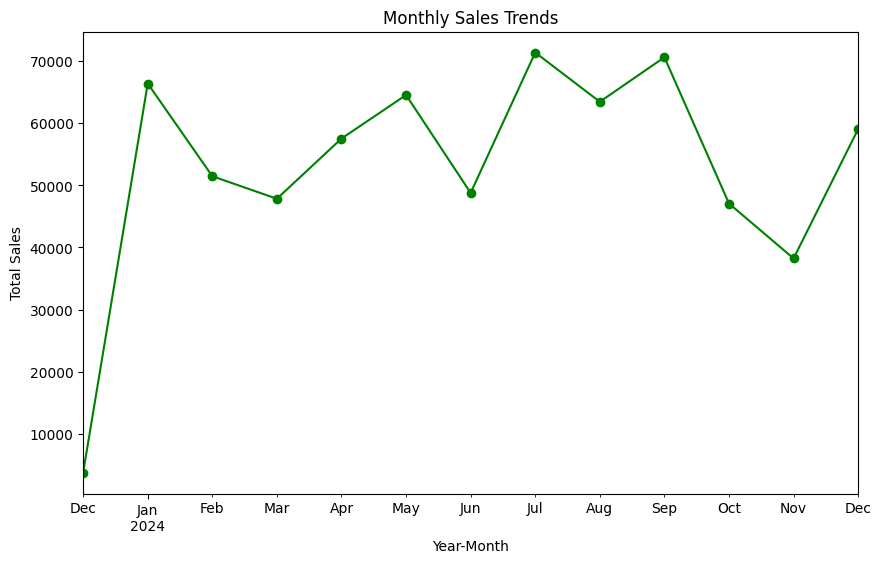

Davies-Bouldin Index: 0.8956923630972515


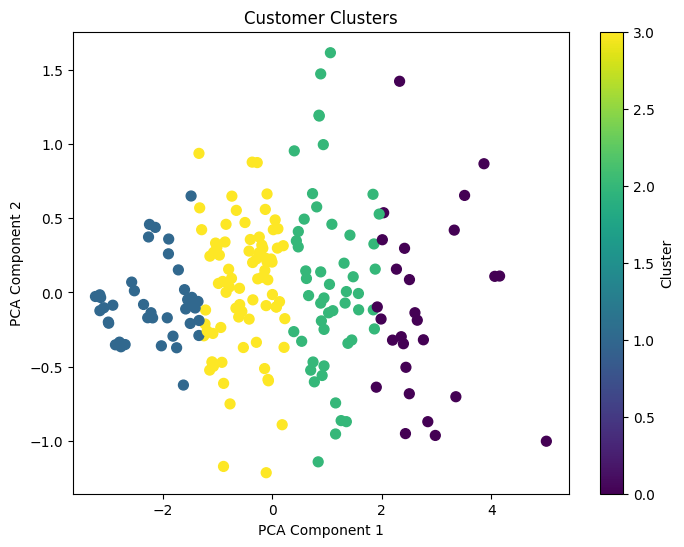

In [1]:
# Author: Tushar Anil Lawande
# Purpose: Data Science Assignment for eCommerce Transactions Dataset

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Task 1: Exploratory Data Analysis (EDA)
# ----------------------------------------

# Preview datasets
print("Customers Dataset:")
print(customers.head())
print("\nProducts Dataset:")
print(products.head())
print("\nTransactions Dataset:")
print(transactions.head())

# Check for missing values in datasets
print("\nMissing Values in Customers Dataset:")
print(customers.isnull().sum())
print("\nMissing Values in Products Dataset:")
print(products.isnull().sum())
print("\nMissing Values in Transactions Dataset:")
print(transactions.isnull().sum())

# Distribution of customers by region
region_distribution = customers['Region'].value_counts()
plt.figure(figsize=(8, 6))
region_distribution.plot(kind='bar', color='skyblue', title='Customer Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.show()

# Distribution of product categories
category_distribution = products['Category'].value_counts()
plt.figure(figsize=(8, 6))
category_distribution.plot(kind='bar', color='orange', title='Product Categories')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.show()

# Monthly sales trend
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['YearMonth'] = transactions['TransactionDate'].dt.to_period('M')
monthly_sales = transactions.groupby('YearMonth')['TotalValue'].sum()
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line', marker='o', color='green', title='Monthly Sales Trends')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.show()

# Task 2: Lookalike Model
# -------------------------

# Merge datasets to create a unified table
data = pd.merge(transactions, customers, on='CustomerID')
data = pd.merge(data, products, on='ProductID')

# Create a customer-product matrix
customer_product_matrix = data.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', fill_value=0)

# Normalize the matrix for better similarity computation
scaler = StandardScaler()
normalized_matrix = scaler.fit_transform(customer_product_matrix)

# Compute cosine similarity between customers
similarity_matrix = cosine_similarity(normalized_matrix)

# Create a DataFrame for similarity scores
similarity_df = pd.DataFrame(similarity_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.index)

# Generate lookalike recommendations for the first 20 customers
lookalike_results = {}
for customer in similarity_df.index[:20]:  # Process first 20 customers
    similar_customers = similarity_df.loc[customer].sort_values(ascending=False).index[1:4]  # Top 3
    scores = similarity_df.loc[customer].sort_values(ascending=False).iloc[1:4]
    lookalike_results[customer] = list(zip(similar_customers, scores))

# Save lookalike results to a CSV file
lookalike_df = pd.DataFrame([(key, val[0], val[1]) for key, values in lookalike_results.items() for val in values],
                            columns=['CustomerID', 'SimilarCustomerID', 'Score'])
lookalike_df.to_csv('Lookalike.csv', index=False)

# Task 3: Customer Segmentation / Clustering
# -------------------------------------------

# Prepare data for clustering by aggregating transaction details
clustering_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'ProductID': 'nunique'
}).reset_index()

# Standardize the data for clustering
features = clustering_data.iloc[:, 1:]
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(features)

# Apply K-Means clustering algorithm
kmeans = KMeans(n_clusters=4, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Evaluate clustering quality using Davies-Bouldin Index
db_index = davies_bouldin_score(clustering_data_scaled, clustering_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(clustering_data_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clustering_data['Cluster'], cmap='viridis', s=50)
plt.title('Customer Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Save clustering results to a CSV file
clustering_data.to_csv('ClusteringResults.csv', index=False)
